In [1]:
import torch
from torch import nn
from enformer_pytorch import from_pretrained, Enformer
from enformer_pytorch.finetune import HeadAdapterWrapper
import numpy as np
import random
from scipy.stats import pearsonr
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
import seaborn as sns
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import torchmetrics
from torchmetrics.regression import PearsonCorrCoef
import pickle as pkl

# HCMI Validation Testing

In this notebook we will attempt to test our fine-tuned model on TCGA dataset on genes from the HCMI cohort. The TCGA cohort has significant differences in expression level vs. the HCMI cohort, where over half of the genes are shown to have significant differences in expression. 

First, let's see differences in all three cohorts for expression data. We began to take a look at this in the CRC_PCA notebook but let's take a dive into what types of genes have significant differences in expression and whether these are predominantly genes with low expression. 

In [2]:
# Load gene counts and metadata in
gene_counts = pd.read_csv('/pollard/home/aravi1/crc_gene_counts.tsv', sep='\t')
metadata = pd.read_csv('/pollard/home/aravi1/crc_metadata.tsv', sep='\t')

# Rename count columns to each biosample ID 
biosample_id = metadata['File.Name'].str.split('.').str[0]
gene_counts.columns.values[3:] = biosample_id 
metadata['id'] = metadata['File.Name'].str.split('.').str[0]

In [3]:
### INPUTS
# test sequences 
normalization = False
gene_counts = gene_counts[gene_counts['gene_name'].duplicated() == False]

anova_sig_genes = pd.read_csv("anova_hcmi_tcga_sig.tsv", sep='\t')

hcmi_samples = pd.concat([pd.Series(['gene_id', 'gene_name', 'gene_type']), metadata.id[metadata['Project'].str.contains('HCMI')]])
filtered_counts = gene_counts.loc[:, gene_counts.columns.isin(hcmi_samples)]

filtered_counts['median'] = filtered_counts.iloc[:,3:].median(axis=1)
filtered_counts = filtered_counts[['gene_id', 'gene_name', 'gene_type', 'median']]

filtered_counts['sig_gene'] = 'No'
filtered_counts.loc[filtered_counts['gene_name'].isin(anova_sig_genes['0']), 'sig_gene'] = 'Yes'
                              
tcga_samples = pd.concat([pd.Series(['gene_id', 'gene_name', 'gene_type']), metadata.id[metadata['Project'].str.contains('TCGA')]])
tcga_counts = gene_counts.loc[:, gene_counts.columns.isin(tcga_samples)]
tcga_counts['median'] = tcga_counts.iloc[:,3:].median(axis=1)
tcga_counts['sig_gene'] = filtered_counts['sig_gene']

/tmp/ipykernel_3709134/3686203740.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_counts['median'] = filtered_counts.iloc[:,3:].median(axis=1)
/tmp/ipykernel_3709134/3686203740.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tcga_counts['median'] = tcga_counts.iloc[:,3:].median(axis=1)
/tmp/ipykernel_3709134/3686203740.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

Text(0.5, 1.0, 'Log-transformed median counts')

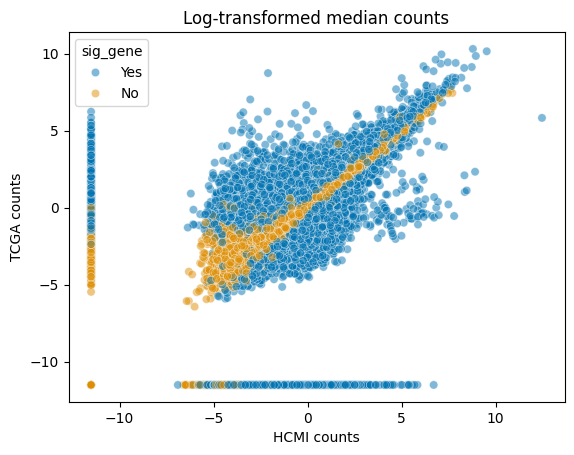

In [4]:
median_count_plot = pd.concat([pd.Series(filtered_counts['gene_name']), pd.Series(np.log(filtered_counts['median'] + 0.00001)), pd.Series(np.log(tcga_counts['median'] + 0.00001)), pd.Series(filtered_counts['sig_gene'])], axis=1)
median_count_plot.columns = ['gene_name', 'HCMI counts', 'TCGA counts', 'sig_gene']

ax = sns.scatterplot(data=median_count_plot, x='HCMI counts', y='TCGA counts', hue='sig_gene', palette='colorblind', alpha=0.5)
ax.set_title("Log-transformed median counts")

In [5]:
TSS_centered_genes = pd.read_csv('Enformer_genomic_regions_TSSCenteredGenes_FixedOverlapRemoval.csv')
print(filtered_counts[filtered_counts['gene_name'].isin(TSS_centered_genes['gene_name'])].shape)
filtered_counts = filtered_counts[filtered_counts['gene_name'].isin(TSS_centered_genes['gene_name'])]

(17539, 5)


In [6]:
filtered_counts

,gene_id,gene_name,gene_type,median,sig_gene
0,ENSG00000000003.15,TSPAN6,protein_coding,72.59280,Yes
1,ENSG00000000005.6,TNMD,protein_coding,0.59015,No
2,ENSG00000000419.13,DPM1,protein_coding,134.77905,No
3,ENSG00000000457.14,SCYL3,protein_coding,9.32565,Yes
4,ENSG00000000460.17,C1orf112,protein_coding,6.71380,No
...,...,...,...,...,...
60609,ENSG00000288607.1,ELOA3B,protein_coding,0.00000,Yes
60612,ENSG00000288611.1,NPBWR1,protein_coding,0.01695,No
60616,ENSG00000288616.1,ELOA3D,protein_coding,0.00000,Yes
60627,ENSG00000288631.1,ELOA3,protein_coding,0.00000,Yes


Text(0.5, 1.0, 'Log-transformed median counts')

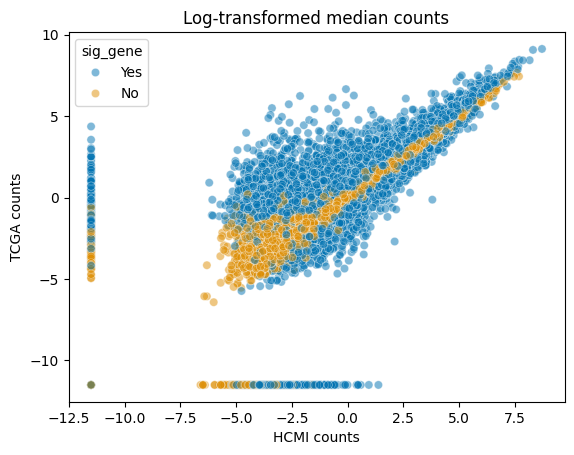

In [7]:
median_count_plot = pd.concat([pd.Series(filtered_counts['gene_name']), pd.Series(np.log(filtered_counts['median'] + 0.00001)), pd.Series(np.log(tcga_counts['median'] + 0.00001)), pd.Series(filtered_counts['sig_gene'])], axis=1)
median_count_plot.columns = ['gene_name', 'HCMI counts', 'TCGA counts', 'sig_gene']

ax = sns.scatterplot(data=median_count_plot, x='HCMI counts', y='TCGA counts', hue='sig_gene', palette='colorblind', alpha=0.5)
ax.set_title("Log-transformed median counts")

In [8]:
TSS_centered_genes = TSS_centered_genes[TSS_centered_genes['gene_name'].isin(filtered_counts['gene_name'])]

# obtain training, validation and test genes here
test_genes = TSS_centered_genes['gene_name'][TSS_centered_genes['set'] == "test"]


### INPUTS
# validation sequences
# test sequences 

### shorten sequences from 196,608 bp to 49,152 as interval length. 
TSS_centered_genes['starts'] = (TSS_centered_genes['starts'] + ((196608 / 8) * 3)).astype(int)
TSS_centered_genes['ends'] = (TSS_centered_genes['ends'] - ((196608 / 8) * 3)).astype(int)
assert (TSS_centered_genes['ends'] - TSS_centered_genes['starts'] == 49152).all()
assert (TSS_centered_genes['ends'] - TSS_centered_genes['gene_start'].astype(int) == 24576).all()

test_sequences = TSS_centered_genes[TSS_centered_genes['gene_name'].isin(test_genes)]

In [9]:
### OUTPUTS
# testing tracks 
test_tracks = filtered_counts[filtered_counts['gene_name'].isin(test_genes)]

In [10]:
#### DEFINE TARGET VARIABLES 
target_length = 384
TSS_tensor_pos1, TSS_tensor_pos2 = (target_length / 2) - 1, (target_length / 2)
batch_size = 4

In [11]:
test_sequences = pd.merge(test_sequences, test_tracks, on="gene_name", how="inner")
test_sequences.to_csv("test_sequences.bed", sep='\t', header=None, index=None)

### Test Data Loader Here

In [12]:
import random
import torch
from enformer_pytorch import from_pretrained, Enformer, GenomeIntervalDataset
from enformer_pytorch.finetune import HeadAdapterWrapper
from scipy.stats import pearsonr
import polars as pl

np.random.seed(150)

filter_test = lambda df: df.filter(pl.col('column_4') == 'test')
test_ds = GenomeIntervalDataset(
    bed_file = 'test_sequences.bed',                       
    fasta_file = 'hg38.fa',
    filter_df_fn = filter_test,
    return_seq_indices = True,                         
    context_length = 49_152
)

In [14]:
import torch
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, sequences, targets, genes):
        self.sequences = sequences
        self.targets = targets
        self.gene = genes 

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = ((self.sequences[idx]) if len(self.sequences[idx]) > 0 else torch.zeros((1,)).clone().detach()).cuda() # Handling empty lists
        target = torch.tensor(self.targets[idx]).cuda()
        gene = self.gene[idx]
        return sequence, target, gene

In [15]:
# Create DataLoader instances
torch.manual_seed(42)
np.random.seed(150)

test = MyDataset(test_ds, test_sequences['median'], test_sequences['gene_name'])
test_loader = DataLoader(test, batch_size=batch_size)

In [17]:
for seq in test_loader:
    print(seq)

[tensor([[3, 1, 0,  ..., 0, 1, 2],
        [3, 2, 3,  ..., 3, 3, 2],
        [3, 1, 3,  ..., 3, 2, 0],
        [0, 0, 3,  ..., 3, 2, 2]], device='cuda:0'), tensor([28.3770,  0.0000,  0.0000,  0.0000], device='cuda:0',
       dtype=torch.float64), ('RHOU', 'OR14C36', 'OR2T4', 'OR2T6')]
[tensor([[2, 3, 0,  ..., 3, 1, 1],
        [2, 3, 2,  ..., 3, 3, 2],
        [2, 0, 3,  ..., 2, 1, 0],
        [3, 1, 0,  ..., 0, 1, 0]], device='cuda:0'), tensor([0., 0., 0., 0.], device='cuda:0', dtype=torch.float64), ('OR2T1', 'OR2T2', 'OR2T3', 'OR2T5')]
[tensor([[3, 3, 2,  ..., 0, 1, 3],
        [3, 0, 2,  ..., 0, 3, 3],
        [3, 1, 1,  ..., 2, 3, 2],
        [3, 3, 1,  ..., 2, 3, 1]], device='cuda:0'), tensor([0., 0., 0., 0.], device='cuda:0', dtype=torch.float64), ('OR2G6', 'OR2T29', 'OR2T34', 'OR2T10')]
[tensor([[3, 3, 0,  ..., 0, 2, 2],
        [0, 2, 2,  ..., 2, 3, 1],
        [2, 0, 0,  ..., 1, 0, 2],
        [0, 0, 0,  ..., 3, 0, 3]], device='cuda:0'), tensor([0.0000, 0.0000, 0.0000, 1.1381]

[tensor([[0, 0, 3,  ..., 3, 0, 0],
        [1, 3, 2,  ..., 3, 1, 0],
        [1, 1, 3,  ..., 0, 1, 1],
        [0, 2, 0,  ..., 3, 3, 0]], device='cuda:0'), tensor([1.5450e-02, 8.5780e+01, 3.2447e+01, 2.8596e+01], device='cuda:0',
       dtype=torch.float64), ('LRRC4C', 'API5', 'TTC17', 'HSD17B12')]
[tensor([[1, 1, 2,  ..., 2, 0, 1],
        [1, 0, 0,  ..., 3, 0, 0],
        [0, 0, 3,  ..., 0, 0, 3],
        [0, 1, 3,  ..., 0, 2, 2]], device='cuda:0'), tensor([2.9295e+01, 2.8505e-01, 2.3400e-02, 4.7234e+00], device='cuda:0',
       dtype=torch.float64), ('ALKBH3', 'C11orf96', 'ACCSL', 'ACCS')]
[tensor([[0, 1, 0,  ..., 3, 3, 0],
        [2, 2, 3,  ..., 1, 3, 3],
        [0, 1, 1,  ..., 3, 0, 0],
        [3, 1, 1,  ..., 3, 2, 3]], device='cuda:0'), tensor([29.6955,  0.3529, 16.3430,  1.1162], device='cuda:0',
       dtype=torch.float64), ('EXT2', 'ALX4', 'CD82', 'TSPAN18')]
[tensor([[1, 3, 3,  ..., 0, 0, 2],
        [1, 0, 2,  ..., 0, 1, 1],
        [1, 0, 3,  ..., 3, 0, 0],
        [1, 2

[tensor([[3, 0, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 3, 0, 1],
        [2, 1, 1,  ..., 2, 3, 3],
        [2, 3, 1,  ..., 3, 1, 1]], device='cuda:0'), tensor([182.5254,   0.3150,  82.2356,  19.6622], device='cuda:0',
       dtype=torch.float64), ('HNRNPC', 'RPGRIP1', 'SUPT16H', 'CHD8')]
[tensor([[3, 2, 2,  ..., 1, 3, 3],
        [3, 3, 3,  ..., 3, 0, 1],
        [3, 3, 2,  ..., 2, 3, 2],
        [0, 2, 0,  ..., 3, 3, 2]], device='cuda:0'), tensor([25.7230, 10.9557, 17.4778,  0.4725], device='cuda:0',
       dtype=torch.float64), ('TOX4', 'RAB2B', 'METTL3', 'SALL2')]
[tensor([[3, 3, 0,  ..., 0, 3, 0],
        [3, 2, 1,  ..., 2, 3, 3],
        [0, 2, 0,  ..., 2, 3, 2],
        [2, 0, 3,  ..., 0, 1, 3]], device='cuda:0'), tensor([  0.0000,   0.0000,   0.0000, 290.0022], device='cuda:0',
       dtype=torch.float64), ('OR10G3', 'OR10G2', 'OR4E2', 'DAD1')]
[tensor([[0, 0, 0,  ..., 3, 2, 3],
        [3, 0, 2,  ..., 3, 3, 2],
        [0, 0, 0,  ..., 3, 3, 1],
        [1, 3, 0,  ..., 3, 1,

[tensor([[0, 2, 2,  ..., 0, 2, 2],
        [1, 1, 0,  ..., 3, 3, 3],
        [0, 0, 1,  ..., 2, 0, 0],
        [3, 3, 2,  ..., 3, 3, 0]], device='cuda:0'), tensor([ 0.0000, 33.1394,  9.8462,  4.1716], device='cuda:0',
       dtype=torch.float64), ('CLEC14A', 'SEC23A', 'GEMIN2', 'TRAPPC6B')]
[tensor([[1, 1, 3,  ..., 0, 1, 3],
        [2, 2, 3,  ..., 1, 3, 0],
        [0, 0, 3,  ..., 0, 3, 2],
        [0, 3, 3,  ..., 2, 3, 2]], device='cuda:0'), tensor([58.5602, 13.2984, 17.9703,  0.0000], device='cuda:0',
       dtype=torch.float64), ('PNN', 'MIA2', 'FBXO33', 'LRFN5')]
[tensor([[1, 0, 2,  ..., 1, 1, 0],
        [0, 2, 2,  ..., 3, 2, 3],
        [3, 3, 3,  ..., 1, 0, 2],
        [3, 2, 2,  ..., 0, 0, 1]], device='cuda:0'), tensor([0.0000, 2.5634, 6.1408, 6.6411], device='cuda:0', dtype=torch.float64), ('FSCB', 'C14orf28', 'TOGARAM1', 'KLHL28')]
[tensor([[1, 1, 3,  ..., 3, 3, 0],
        [2, 2, 1,  ..., 0, 2, 3],
        [3, 2, 0,  ..., 0, 1, 0],
        [0, 3, 0,  ..., 1, 1, 3]], device=

[tensor([[2, 0, 3,  ..., 0, 1, 3],
        [0, 1, 0,  ..., 3, 0, 2],
        [0, 0, 0,  ..., 1, 1, 3],
        [3, 3, 2,  ..., 0, 1, 3]], device='cuda:0'), tensor([5.8623e+01, 4.3850e-02, 6.1170e+01, 6.3229e+00], device='cuda:0',
       dtype=torch.float64), ('SPTLC2', 'C14orf178', 'SNW1', 'ADCK1')]
[tensor([[2, 0, 0,  ..., 1, 1, 3],
        [3, 3, 2,  ..., 1, 3, 3],
        [0, 2, 1,  ..., 0, 3, 2],
        [3, 3, 1,  ..., 2, 3, 2]], device='cuda:0'), tensor([1.4516, 0.0300, 0.1060, 3.4258], device='cuda:0', dtype=torch.float64), ('NRXN3', 'DIO2', 'TSHR', 'CEP128')]
[tensor([[3, 1, 3,  ..., 0, 3, 2],
        [3, 0, 2,  ..., 2, 1, 3],
        [0, 1, 1,  ..., 0, 0, 3],
        [3, 1, 3,  ..., 2, 2, 0]], device='cuda:0'), tensor([1.8458e+01, 4.9665e+00, 4.8684e+01, 2.3500e-03], device='cuda:0',
       dtype=torch.float64), ('GTF2A1', 'STON2', 'SEL1L', 'FLRT2')]
[tensor([[0, 1, 1,  ..., 3, 1, 3],
        [2, 1, 0,  ..., 2, 1, 3],
        [0, 0, 1,  ..., 3, 1, 0],
        [3, 1, 0,  ..., 3

[tensor([[0, 2, 2,  ..., 0, 2, 0],
        [0, 0, 0,  ..., 2, 2, 3],
        [0, 2, 1,  ..., 1, 2, 2],
        [0, 3, 0,  ..., 3, 0, 0]], device='cuda:0'), tensor([19.6197, 17.1645,  5.7433, 20.5971], device='cuda:0',
       dtype=torch.float64), ('ELOF1', 'ZNF627', 'ACP5', 'ZNF823')]
[tensor([[1, 1, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 0, 2, 2],
        [3, 2, 2,  ..., 3, 3, 2],
        [0, 0, 0,  ..., 3, 3, 3]], device='cuda:0'), tensor([ 5.5103,  0.8957, 14.2051,  1.3694], device='cuda:0',
       dtype=torch.float64), ('ZNF441', 'ZNF491', 'ZNF440', 'ZNF439')]
[tensor([[3, 2, 1,  ..., 0, 0, 0],
        [0, 1, 0,  ..., 1, 1, 0],
        [1, 2, 3,  ..., 3, 1, 0],
        [0, 0, 3,  ..., 2, 2, 3]], device='cuda:0'), tensor([15.0095, 14.7901,  1.0263,  2.9221], device='cuda:0',
       dtype=torch.float64), ('ZNF69', 'ZNF700', 'ZNF763', 'ZNF433')]
[tensor([[0, 1, 0,  ..., 0, 3, 0],
        [1, 1, 0,  ..., 3, 3, 3],
        [0, 0, 3,  ..., 2, 2, 2],
        [3, 3, 2,  ..., 3, 2, 1]],

[tensor([[1, 3, 0,  ..., 3, 0, 3],
        [0, 1, 0,  ..., 0, 2, 2],
        [0, 2, 2,  ..., 1, 3, 3],
        [3, 3, 3,  ..., 0, 2, 0]], device='cuda:0'), tensor([5.0318, 4.8542, 2.0013, 3.5702], device='cuda:0', dtype=torch.float64), ('ZNF567', 'ZNF850', 'ZNF345', 'ZNF790')]
[tensor([[0, 0, 3,  ..., 2, 2, 2],
        [0, 3, 3,  ..., 1, 3, 3],
        [0, 2, 3,  ..., 3, 0, 3],
        [2, 0, 1,  ..., 0, 3, 0]], device='cuda:0'), tensor([4.9337, 1.6264, 3.9954, 2.9759], device='cuda:0', dtype=torch.float64), ('ZNF420', 'ZNF585A', 'ZNF585B', 'ZNF383')]
[tensor([[0, 3, 0,  ..., 3, 1, 0],
        [0, 1, 3,  ..., 0, 3, 0],
        [3, 3, 3,  ..., 1, 3, 0],
        [1, 0, 2,  ..., 2, 0, 2]], device='cuda:0'), tensor([2.3528, 2.4009, 0.8200, 0.3110], device='cuda:0', dtype=torch.float64), ('ZNF527', 'ZNF570', 'ZNF569', 'ZNF793')]
[tensor([[3, 3, 1,  ..., 0, 2, 3],
        [3, 1, 0,  ..., 3, 1, 3],
        [3, 2, 2,  ..., 1, 0, 1],
        [0, 0, 1,  ..., 1, 0, 0]], device='cuda:0'), tensor([

[tensor([[3, 2, 2,  ..., 0, 1, 0],
        [3, 2, 3,  ..., 0, 0, 0],
        [0, 3, 3,  ..., 3, 3, 3],
        [0, 3, 2,  ..., 3, 3, 0]], device='cuda:0'), tensor([67.7950,  0.1717, 19.4191, 16.0813], device='cuda:0',
       dtype=torch.float64), ('ETHE1', 'PINLYP', 'XRCC1', 'IRGQ')]
[tensor([[3, 2, 3,  ..., 0, 1, 3],
        [2, 3, 0,  ..., 1, 1, 1],
        [1, 1, 0,  ..., 3, 2, 2],
        [2, 3, 1,  ..., 3, 1, 3]], device='cuda:0'), tensor([ 6.7441,  0.7202,  9.9082, 11.8120], device='cuda:0',
       dtype=torch.float64), ('ZNF576', 'SRRM5', 'ZNF428', 'CADM4')]
[tensor([[3, 2, 3,  ..., 3, 2, 3],
        [0, 3, 3,  ..., 2, 2, 2],
        [0, 0, 2,  ..., 1, 1, 1],
        [1, 3, 1,  ..., 3, 1, 3]], device='cuda:0'), tensor([12.9284,  0.0000, 10.6941, 42.8718], device='cuda:0',
       dtype=torch.float64), ('PLAUR', 'IRGC', 'SMG9', 'KCNN4')]
[tensor([[3, 3, 2,  ..., 3, 0, 0],
        [3, 3, 1,  ..., 0, 1, 3],
        [0, 0, 0,  ..., 1, 3, 1],
        [0, 0, 0,  ..., 2, 3, 2]], device=

[tensor([[1, 3, 2,  ..., 2, 3, 2],
        [3, 1, 0,  ..., 0, 2, 2],
        [1, 0, 3,  ..., 0, 0, 1],
        [1, 1, 0,  ..., 3, 3, 1]], device='cuda:0'), tensor([ 8.6666, 16.0366, 18.1228,  6.6410], device='cuda:0',
       dtype=torch.float64), ('ZNF600', 'ZNF28', 'ZNF468', 'ZNF320')]
[tensor([[2, 2, 1,  ..., 2, 0, 2],
        [0, 0, 3,  ..., 0, 2, 2],
        [0, 0, 3,  ..., 0, 1, 0],
        [3, 0, 0,  ..., 0, 1, 0]], device='cuda:0'), tensor([13.1402, 13.2473,  0.0168,  0.0166], device='cuda:0',
       dtype=torch.float64), ('ZNF888', 'ZNF816', 'ERVV-1', 'ERVV-2')]
[tensor([[2, 0, 2,  ..., 3, 0, 1],
        [1, 3, 1,  ..., 2, 2, 1],
        [3, 3, 2,  ..., 2, 0, 0],
        [2, 2, 0,  ..., 3, 3, 0]], device='cuda:0'), tensor([ 0.0221, 15.5326,  0.6084,  0.0000], device='cuda:0',
       dtype=torch.float64), ('NLRP12', 'MYADM', 'PRKCG', 'CACNG7')]
[tensor([[2, 1, 2,  ..., 0, 0, 2],
        [2, 3, 0,  ..., 1, 2, 0],
        [3, 0, 1,  ..., 2, 3, 2],
        [3, 2, 0,  ..., 0, 3, 3]]

[tensor([[1, 3, 1,  ..., 1, 3, 1],
        [3, 1, 3,  ..., 0, 2, 2],
        [2, 3, 1,  ..., 2, 3, 3],
        [2, 1, 3,  ..., 2, 0, 2]], device='cuda:0'), tensor([67.6485, 10.4110,  3.5956, 16.0064], device='cuda:0',
       dtype=torch.float64), ('CRKL', 'AIFM3', 'LZTR1', 'THAP7')]
[tensor([[2, 0, 3,  ..., 1, 1, 0],
        [2, 0, 2,  ..., 2, 2, 1],
        [2, 2, 1,  ..., 2, 0, 1],
        [1, 1, 1,  ..., 0, 2, 1]], device='cuda:0'), tensor([0.2842, 1.7949, 0.0220, 0.0000], device='cuda:0', dtype=torch.float64), ('P2RX6', 'SLC7A4', 'LRRC74B', 'GGT2')]
[tensor([[2, 2, 2,  ..., 0, 2, 2],
        [2, 3, 2,  ..., 2, 3, 1],
        [1, 3, 1,  ..., 2, 1, 3],
        [0, 2, 2,  ..., 3, 3, 3]], device='cuda:0'), tensor([ 0.3092,  0.0000, 58.8564, 40.3177], device='cuda:0',
       dtype=torch.float64), ('TMEM191C', 'RIMBP3C', 'UBE2L3', 'YDJC')]
[tensor([[3, 2, 1,  ..., 3, 2, 2],
        [3, 0, 3,  ..., 3, 1, 1],
        [2, 0, 0,  ..., 3, 0, 2],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda

[tensor([[2, 2, 1,  ..., 2, 2, 2],
        [0, 0, 3,  ..., 1, 1, 0],
        [2, 3, 0,  ..., 3, 1, 3],
        [0, 3, 0,  ..., 3, 2, 2]], device='cuda:0'), tensor([15.3728,  0.6129,  9.8570,  8.2404], device='cuda:0',
       dtype=torch.float64), ('AIFM1', 'RAB33A', 'ZNF280C', 'SLC25A14')]
[tensor([[0, 1, 3,  ..., 0, 2, 0],
        [1, 1, 1,  ..., 1, 3, 3],
        [0, 3, 1,  ..., 3, 3, 0],
        [3, 1, 0,  ..., 1, 1, 1]], device='cuda:0'), tensor([3.1750e-02, 3.2414e+01, 1.7350e+01, 0.0000e+00], device='cuda:0',
       dtype=torch.float64), ('GPR119', 'RBMX2', 'ENOX2', 'ARHGAP36')]
[tensor([[0, 3, 2,  ..., 1, 0, 2],
        [1, 0, 1,  ..., 1, 1, 0],
        [0, 1, 3,  ..., 0, 1, 0],
        [1, 0, 0,  ..., 3, 3, 0]], device='cuda:0'), tensor([ 0.0000,  0.1046, 46.3925,  0.0774], device='cuda:0',
       dtype=torch.float64), ('OR13H1', 'IGSF1', 'STK26', 'FRMD7')]
[tensor([[1, 3, 2,  ..., 0, 1, 3],
        [2, 1, 0,  ..., 3, 1, 3],
        [0, 0, 1,  ..., 3, 3, 0],
        [0, 1, 3,  

## Load Enformer Model

Next we will load the fine-tuned Enformer model in here - this is the model that was trained on raw counts. 

In [28]:
# Define Enformer revised/fine-tuned model here. 
from torch.nn import Sequential 

# 1,536 * 2 - pointwise convolutional
# compute target length based on tensor shape 

class EnformerFineTuning(nn.Module):
    def __init__(
        self,
        enformer,
        num_tracks,
        post_transformer_embed = False, # whether to take the embeddings from right after the transformer, instead of after the final pointwise convolutional - this would add another layernorm
        ):
        super().__init__()
        assert isinstance(enformer, Enformer)
        enformer_hidden_dim = enformer.dim * (2 if not post_transformer_embed else 1)
        
        self.enformer = enformer.cuda()

        if (normalization == True):
            self.to_gene_counts = Sequential(
                nn.Linear(enformer_hidden_dim, num_tracks, bias=True).cuda(),
                # nn.Softplus(beta=1, threshold=20).cuda()
            )
        else:
            self.to_gene_counts = Sequential(
                nn.Linear(enformer_hidden_dim, num_tracks, bias=True).cuda(),
                nn.Softplus(beta=1, threshold=20).cuda()
            )
    
    def forward(
        self,
        seq,
        target = None,
        freeze_enformer = False,
        finetune_enformer_ln_only = False,
        finetune_last_n_layers_only = None,
    ):
        enformer_kwargs = dict()

        # enformer_kwargs = dict(target_length = 1)
        
        # returning only the embeddings here 
        embeddings = self.enformer(seq, return_only_embeddings=True)
        # print(embeddings.size())
        
        # batch_dim, seq_dim, feature_dim = embeddings.size()
        
        # compute center tensor by floor dividing - convention is just to take the left 
        
        # take center positions of embedding and average the two 
        TSS_tensor1 = embeddings[:, int(TSS_tensor_pos1)]
        # TSS_tensor2 = embeddings[:, int(TSS_tensor_pos2)]
        # mean_embeddings_TSS = torch.add(TSS_tensor1, TSS_tensor2) / 2
        
        # convert mean embedding to gene count value 
        preds = self.to_gene_counts(TSS_tensor1)

        return preds
    
    def _log(self, t, eps = 1e-20):
        return torch.log(t.clamp(min = eps))
    
    # LOSS FUNCTION for Enformer 
    def poisson_loss(self, pred, target):
        return (pred - target * self._log(pred)).mean()

In [29]:
file_path = "/pollard/home/aravi1/240506_enformer_raw/enformer_finetuned.pkl"
with open(file_path, 'rb') as f:
    model = pkl.load(f)

In [35]:
# Assuming you have a test_loader similar to train_loader and val_loader
test_targets = []
test_outputs = []
test_loss = []
test_genes = []

model.eval()  # Set the model to evaluation mode

with torch.no_grad():
    l = 0
    for test_seq, test_target, test_gene in test_loader:
        test_target = test_target.reshape([test_target.size()[0], 1])
        test_output = model(test_seq)
        if (normalization == True):
            test_loss_batch = criterion(test_output.float(), test_target.float())
        else: 
            test_loss_batch = model.poisson_loss(test_output, test_target).item()
        
        test_genes.append(test_gene)
        test_targets.append(test_target)
        test_outputs.append(test_output)
        test_loss.append(test_loss_batch)
        
        if (l % 100 == 0):
            print(l)
        
        l += 1

if (normalization == True):
    test_accuracy = pearsonr(torch.cat(test_outputs).cpu().detach().numpy().flatten(), torch.cat(test_targets).cpu().detach().numpy().flatten())
    test_loss_mean = np.mean(np.array([tensor.cpu().numpy() for tensor in test_loss]))
else: 
    test_loss_mean = np.mean(np.array(test_loss))
    test_accuracy = pearsonr(torch.log(torch.cat(test_outputs) + 0.00001).cpu().detach().numpy().flatten(), torch.log(torch.cat(test_targets) + 0.00001).cpu().detach().numpy().flatten())
    
print(f"Test Loss: {test_loss_mean}, Test Accuracy: {round(test_accuracy[0], 5)}")

0
100
200
300
400
Test Loss: -46.62415573736157, Test Accuracy: 0.63027


/tmp/ipykernel_1314807/3905598491.py:4: RuntimeWarning: divide by zero encountered in log
  test_targets_all = np.log(torch.cat(test_targets).cpu().detach().numpy().flatten())


Text(0.5, 0.98, 'Test Set Predicted vs. Observed\n')

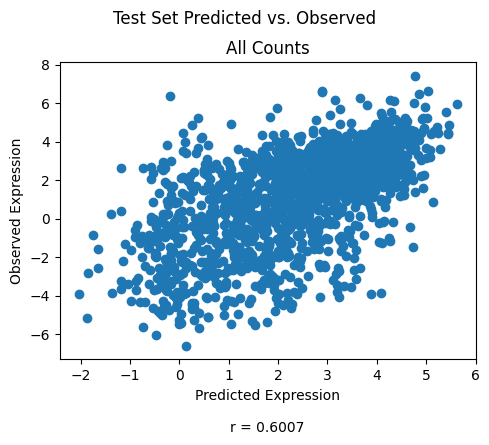

In [33]:
test_outputs_all = np.log(torch.cat(test_outputs).cpu().detach().numpy().flatten())
test_targets_all = np.log(torch.cat(test_targets).cpu().detach().numpy().flatten())
test_genes = np.array(test_genes).flatten()

all_counts = pd.concat([pd.Series(test_outputs_all), pd.Series(test_targets_all), test_genes], axis=1)
all_counts.columns = ["outputs", "targets", "genes"]

all_counts = all_counts[all_counts['targets'] > -10]

all_correlation = round(pearsonr(all_counts['outputs'], all_counts['targets'])[0], 4)

median_count_plot = pd.concat([pd.Series(filtered_counts['gene_name']), pd.Series(np.log(filtered_counts['median'] + 0.00001)), pd.Series(np.log(tcga_counts['median'] + 0.00001)), pd.Series(filtered_counts['sig_gene'])], axis=1)
median_count_plot.columns = ['gene_name', 'HCMI counts', 'TCGA counts', 'sig_gene']

ax = sns.scatterplot(data=median_count_plot, x='HCMI counts', y='TCGA counts', hue='sig_gene', palette='colorblind', alpha=0.5)
ax.set_title("Log-transformed median counts")